# 1-S4: LSTM 기초

시퀀스 데이터를 처리하는 LSTM의 개념과 PyTorch 기본 사용법을 학습합니다.

## 학습 목표
1. **RNN 개념** - 순차 데이터 처리 원리
2. **LSTM 구조** - 장기 기억을 위한 게이트 메커니즘
3. **PyTorch 기본** - Tensor, nn.Module
4. **LSTM 모델 구현** - 간단한 분류기 만들기
5. **FDS 적용** - 거래 시퀀스 학습 개념

## 예상 시간
약 30분

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch 버전: {torch.__version__}")
print(f"사용 장치: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch 버전: 2.5.1
사용 장치: cuda
GPU: NVIDIA GeForce RTX 2070 SUPER


---
## 1. RNN 개념

### 1-1. 왜 RNN이 필요한가?

**일반 신경망의 한계**
- 입력을 독립적으로 처리
- "순서" 정보를 활용하지 못함

**예시: 문장 분류**
```
"나는 밥을 먹었다"
"먹었다 밥을 나는"
```
→ 일반 신경망은 같은 입력으로 처리
→ 하지만 의미가 다름!

**RNN의 해결책**
- 이전 상태(hidden state)를 다음 스텝에 전달
- 순서 정보를 "기억"하며 처리

### 1-2. RNN 구조

```
입력 x1 → [RNN Cell] → h1 (hidden state)
              ↓
입력 x2 → [RNN Cell] → h2 (이전 h1 사용)
              ↓
입력 x3 → [RNN Cell] → h3 (이전 h2 사용)
              ↓
           최종 출력
```

**수식**
```
h_t = tanh(W_h * h_{t-1} + W_x * x_t + b)
```

- `h_t`: 현재 hidden state
- `h_{t-1}`: 이전 hidden state
- `x_t`: 현재 입력

In [2]:
# 📚 RNN의 동작 원리 시각화
# 간단한 시퀀스: [1, 2, 3, 4, 5]

sequence = [1, 2, 3, 4, 5]
hidden = 0  # 초기 hidden state
W_h, W_x = 0.5, 0.3  # 가중치 (예시)

print("RNN 동작 시뮬레이션")
print("-" * 40)

for t, x in enumerate(sequence):
    new_hidden = np.tanh(W_h * hidden + W_x * x)
    print(f"t={t}: x={x}, h_prev={hidden:.3f} → h_new={new_hidden:.3f}")
    hidden = new_hidden

print("-" * 40)
print(f"최종 hidden state: {hidden:.3f}")
print("→ 시퀀스 전체 정보가 축적됨")

RNN 동작 시뮬레이션
----------------------------------------
t=0: x=1, h_prev=0.000 → h_new=0.291
t=1: x=2, h_prev=0.291 → h_new=0.633
t=2: x=3, h_prev=0.633 → h_new=0.839
t=3: x=4, h_prev=0.839 → h_new=0.925
t=4: x=5, h_prev=0.925 → h_new=0.961
----------------------------------------
최종 hidden state: 0.961
→ 시퀀스 전체 정보가 축적됨


### 1-3. RNN의 한계: Vanishing Gradient

**문제**
- 시퀀스가 길어지면 초반 정보가 사라짐
- 역전파 시 그래디언트가 0에 수렴

```
x1 → x2 → x3 → ... → x100 → 출력
↑                           ↓
x1의 영향이 거의 없어짐 (vanishing)
```

**해결책: LSTM!**

---
## 2. LSTM 구조

### 2-1. LSTM (Long Short-Term Memory)

**핵심 아이디어**
- Cell State: 장기 기억 저장소 (고속도로처럼 정보 전달)
- Gate: 정보의 흐름을 제어하는 밸브

### 2-2. 3가지 Gate

| Gate | 역할 | 비유 |
|------|------|------|
| **Forget Gate** | 기존 기억 중 버릴 것 결정 | 잊을 내용 선택 |
| **Input Gate** | 새 정보 중 저장할 것 결정 | 기억할 내용 선택 |
| **Output Gate** | 출력할 정보 결정 | 말할 내용 선택 |

```
                    Cell State (장기 기억)
     ─────────────────→ × ────────────→ + ────────────→
                        ↑               ↑
                   Forget Gate     Input Gate
                   (버릴 것)        (저장할 것)
                        ↑               ↑
     ─────────────────────────────────────────────────→
                     Hidden State
```

### 2-3. LSTM vs RNN 비교

| 특성 | RNN | LSTM |
|------|-----|------|
| 구조 | 단순 | 복잡 (게이트 3개) |
| 장기 기억 | ❌ 어려움 | ✅ Cell State |
| 학습 속도 | 빠름 | 느림 |
| 파라미터 수 | 적음 | 4배 많음 |
| 실무 사용 | 거의 안함 | 많이 사용 |

**GRU (Gated Recurrent Unit)**
- LSTM의 간소화 버전
- Gate 2개 (Reset, Update)
- 성능 비슷, 속도 빠름

---
## 3. PyTorch 기본

### 3-1. Tensor

PyTorch의 기본 데이터 타입 (NumPy의 ndarray와 유사)

In [8]:
# 📚 Tensor 기본

# 생성
a = torch.tensor([1, 2, 3])
b = torch.zeros(3, 4)          # 0으로 채운 3x4
c = torch.randn(3, 4)          # 정규분포 랜덤

print("텐서 생성")
print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")

# NumPy 변환
np_arr = np.array([1, 2, 3])
tensor_from_np = torch.from_numpy(np_arr)
back_to_np = tensor_from_np.numpy()

print(f"\nNumPy → Tensor: {tensor_from_np}")

# GPU로 이동
if torch.cuda.is_available():
    gpu_tensor = c.to(device)
    print(f"\nGPU 텐서: {gpu_tensor.device}")

텐서 생성
a = tensor([1, 2, 3])
b = tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
c = tensor([[-1.6760, -0.0313, -0.0776,  0.4999],
        [-0.7518, -0.1811, -0.1910,  0.2668],
        [-1.0577, -1.2751,  0.1113,  0.7641]])

NumPy → Tensor: tensor([1, 2, 3])

GPU 텐서: cuda:0


In [10]:
# 📚 Tensor 연산

x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)  # 그래디언트 추적
y = x ** 2
z = y.sum()

print(f"x = {x}")
print(f"y = x² = {y}")
print(f"z = sum(y) = {z}")

# 역전파
z.backward()
print(f"\ndz/dx = 2x = {x.grad}")  # [2, 4, 6]

x = tensor([1., 2., 3.], requires_grad=True)
y = x² = tensor([1., 4., 9.], grad_fn=<PowBackward0>)
z = sum(y) = 14.0
tensor(14., grad_fn=<SumBackward0>)

dz/dx = 2x = tensor([2., 4., 6.])


### 3-2. nn.Module

PyTorch에서 모델을 만드는 **기본 틀(클래스)**입니다.

#### nn.Module이 뭔가?

**비유: 레고 조립 설명서**
```
nn.Module = 레고 설명서

1. 어떤 블록(레이어)이 필요한지 정의 → __init__
2. 블록을 어떤 순서로 조립하는지 정의 → forward
```

#### 왜 nn.Module을 상속하나?

```python
class MyModel(nn.Module):  # nn.Module 상속
```

상속하면 PyTorch가 제공하는 기능을 **공짜로** 받음:
- 파라미터 자동 추적 (`model.parameters()`)
- GPU 이동 (`model.to(device)`)
- 학습/평가 모드 전환 (`model.train()`, `model.eval()`)
- 모델 저장/불러오기

#### 필수로 만들어야 하는 것 2가지

| 메서드 | 역할 | 비유 |
|--------|------|------|
| `__init__` | 사용할 레이어 정의 | 레고 블록 꺼내놓기 |
| `forward` | 데이터 흐름 정의 | 블록 조립 순서 |

#### 핵심 개념 미리보기

| 코드 | 의미 |
|------|------|
| `super().__init__()` | 부모(nn.Module) 초기화. **필수!** 안 하면 에러 |
| `nn.Linear(10, 5)` | 입력 10개 → 출력 5개로 변환하는 레이어 (y = Wx + b) |
| `nn.ReLU()` | 활성화 함수. 음수→0, 양수→그대로. 비선형성 추가 |
| `self.xxx = ` | 레이어를 self에 저장해야 PyTorch가 추적함 |

#### 데이터 흐름 시각화

```
입력 [10개]
    ↓
┌─────────┐
│ Linear  │  10 → 5 (가중치 곱하고 더하기)
└─────────┘
    ↓
┌─────────┐
│  ReLU   │  음수를 0으로 (비선형 변환)
└─────────┘
    ↓
┌─────────┐
│ Linear  │  5 → 1 (최종 출력)
└─────────┘
    ↓
출력 [1개]
```

In [14]:
# 📚 간단한 신경망 예제

class SimpleNet(nn.Module):
    """
    간단한 신경망: 입력 → 은닉층 → 출력
    
    예시: 10개 숫자 입력받아서 1개 숫자 출력
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        1단계: 레이어 정의 (레고 블록 꺼내놓기)
        
        Args:
            input_size: 입력 개수 (예: 10)
            hidden_size: 은닉층 크기 (예: 5)
            output_size: 출력 개수 (예: 1)
        """
        # ⚠️ 필수! 부모 클래스 초기화 (안 하면 에러)
        super().__init__()
        
        # 레이어 정의 - self.xxx로 저장해야 PyTorch가 추적함
        self.fc1 = nn.Linear(input_size, hidden_size)   # 10 → 5 변환
        self.relu = nn.ReLU()                            # 활성화 함수
        self.fc2 = nn.Linear(hidden_size, output_size)  # 5 → 1 변환
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        2단계: 데이터 흐름 정의 (블록 조립 순서)
        
        이 메서드는 model(input) 호출하면 자동 실행됨!
        
        Args:
            x: 입력 데이터 (batch, 10)
        Returns:
            출력 (batch, 1)
        """
        # 순서대로 통과
        x = self.fc1(x)   # 1) Linear: 10개 → 5개
        x = self.relu(x)  # 2) ReLU: 음수 → 0
        x = self.fc2(x)   # 3) Linear: 5개 → 1개
        return x

# 모델 생성
model = SimpleNet(input_size=10, hidden_size=5, output_size=1)
print(model)

# 🔥 핵심: model(x) 하면 forward(x)가 자동 호출됨!
sample_input = torch.randn(3, 10)  # 배치 3개, 각각 10개 숫자
output = model(sample_input)       # 내부적으로 forward() 실행

print(f"\n입력: {sample_input.shape}  → (3개 샘플, 10개 피처)")
print(f"출력: {output.shape}  → (3개 샘플, 1개 출력)")

SimpleNet(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

입력: torch.Size([3, 10])  → (3개 샘플, 10개 피처)
출력: torch.Size([3, 1])  → (3개 샘플, 1개 출력)


### 3-3. 학습 루프

딥러닝 학습은 **"예측 → 실수 확인 → 고치기"** 반복입니다.

#### 학습 과정 비유

```
시험 공부하는 것과 같음:

1. 문제 풀기 (순전파)        → model(x)로 예측
2. 채점하기 (손실 계산)      → loss = criterion(예측, 정답)
3. 틀린 이유 분석 (역전파)   → loss.backward()
4. 오답노트 정리 (업데이트)  → optimizer.step()
5. 다음 문제로 (반복)
```

#### 핵심 3줄 이해하기

| 코드 | 역할 | 왜 필요해? |
|------|------|-----------|
| `optimizer.zero_grad()` | 그래디언트 초기화 | 안 하면 이전 그래디언트가 누적됨! |
| `loss.backward()` | 역전파로 그래디언트 계산 | "뭘 얼마나 바꿔야 하나?" 계산 |
| `optimizer.step()` | 가중치 업데이트 | 계산된 방향으로 실제로 수정 |

#### 왜 zero_grad()가 필요해?

```python
# zero_grad() 안 하면?
1번째 배치: grad = 5
2번째 배치: grad = 5 + 3 = 8  ← 누적됨!
3번째 배치: grad = 8 + 4 = 12 ← 계속 누적!

# zero_grad() 하면?
1번째 배치: grad = 5 → 업데이트 → grad = 0 (초기화)
2번째 배치: grad = 3 → 업데이트 → grad = 0 (초기화)
```

#### 전체 코드

```python
# 1. 준비물 정의
model = MyModel()                              # 모델
criterion = nn.BCELoss()                       # 손실함수 (정답과 비교)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 업데이트 방법

# 2. 학습 루프
for epoch in range(num_epochs):           # 전체 데이터 반복 횟수
    for batch_x, batch_y in dataloader:   # 데이터를 조금씩 가져옴
        
        # 순전파: 예측하기
        output = model(batch_x)
        loss = criterion(output, batch_y)  # 얼마나 틀렸나?
        
        # 역전파: 고치기
        optimizer.zero_grad()   # 1) 이전 기록 지우기
        loss.backward()         # 2) 틀린 원인 분석 (그래디언트 계산)
        optimizer.step()        # 3) 가중치 수정
```

---
## 4. LSTM 모델 구현

### 4-1. nn.LSTM 사용법

```python
lstm = nn.LSTM(
    input_size=10,      # 입력 피처 수
    hidden_size=64,     # hidden state 크기
    num_layers=2,       # LSTM 층 수
    batch_first=True,   # 입력 형태: (batch, seq, features)
    dropout=0.2         # 드롭아웃 (2층 이상일 때)
)
```

#### LSTM은 3개를 반환한다!

```python
output, (hidden, cell) = lstm(input)
```

**왜 3개야?**

| 반환값 | 의미 | 비유 |
|--------|------|------|
| `output` | **모든** timestep의 hidden state | 수업 중 매 순간의 필기 |
| `hidden` | **마지막** timestep의 hidden state | 수업 끝나고 정리한 요약 |
| `cell` | Cell State (장기 기억) | 머릿속 장기 기억 |

#### output vs hidden 차이

```
시퀀스 길이 = 5일 때:

output: [h1, h2, h3, h4, h5]  ← 5개 전부 (모든 순간)
hidden: [h5]                   ← 마지막 1개만
```

**그림으로 보면:**
```
x1 → [LSTM] → h1 ─┐
x2 → [LSTM] → h2 ─┼─→ output (전부)
x3 → [LSTM] → h3 ─┤
x4 → [LSTM] → h4 ─┤
x5 → [LSTM] → h5 ─┴─→ hidden (마지막만)
```

#### 언제 뭘 써?

| 용도 | 사용할 값 |
|------|----------|
| **분류** (시퀀스 → 1개 결과) | `hidden` (마지막 요약만 필요) |
| **시퀀스 예측** (시퀀스 → 시퀀스) | `output` (매 순간 결과 필요) |
| **다음 LSTM에 전달** | `hidden`, `cell` 둘 다 |

**FDS에서는?**
- 거래 시퀀스 → 사기 여부 (분류)
- → `hidden[-1]` 사용! (마지막 레이어의 마지막 hidden)

#### 입출력 형태 (batch_first=True)

```
입력:  (batch_size, seq_len, input_size)    예: (32, 10, 15)
                                              → 32개 샘플, 10 timestep, 15 피처

output: (batch_size, seq_len, hidden_size)  예: (32, 10, 64)
hidden: (num_layers, batch_size, hidden_size)  예: (2, 32, 64)
cell:   (num_layers, batch_size, hidden_size)  예: (2, 32, 64)
```

In [16]:
# 📚 LSTM 레이어 테스트

# LSTM 정의
lstm_layer = nn.LSTM(
    input_size=10,      # 각 timestep의 피처 수
    hidden_size=64,     # hidden state 크기
    num_layers=1,
    batch_first=True
)

# 가상 입력: 배치 4, 시퀀스 길이 5, 피처 10
sample_input = torch.randn(4, 5, 10)
print(f"입력 shape: {sample_input.shape}")
print("  → (batch=4, seq_len=5, features=10)")

# LSTM 통과
output, (hidden, cell) = lstm_layer(sample_input)

print(f"\n출력 shape: {output.shape}")
print("  → (batch=4, seq_len=5, hidden=64)")
print(f"\nhidden shape: {hidden.shape}")
print("  → (num_layers=1, batch=4, hidden=64)")
print(f"\ncell shape: {cell.shape}")
print("  → Cell State (장기 기억)")

입력 shape: torch.Size([4, 5, 10])
  → (batch=4, seq_len=5, features=10)

출력 shape: torch.Size([4, 5, 64])
  → (batch=4, seq_len=5, hidden=64)

hidden shape: torch.Size([1, 4, 64])
  → (num_layers=1, batch=4, hidden=64)

cell shape: torch.Size([1, 4, 64])
  → Cell State (장기 기억)


In [17]:
# 📚 FDS용 LSTM 분류기

class LSTMClassifier(nn.Module):
    """
    거래 시퀀스로 사기 탐지하는 LSTM 모델
    
    입력: 최근 N건의 거래 시퀀스
    출력: 다음 거래가 사기일 확률 (0~1)
    """
    
    def __init__(
        self, 
        input_size: int,    # 거래당 피처 수 (예: 15개)
        hidden_size: int,   # LSTM hidden 크기 (예: 64)
        num_layers: int = 1,
        dropout: float = 0.2
    ):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            # ⚠️ dropout은 층이 2개 이상일 때만 의미 있음
            # 1층이면 dropout 적용할 "사이"가 없음!
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_size, 1)  # hidden → 1개 출력
        self.sigmoid = nn.Sigmoid()           # 0~1 확률로 변환
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, features) 형태의 시퀀스
               예: (32, 10, 15) = 32개 샘플, 10건 거래, 15개 피처
        Returns:
            사기 확률 (batch, 1)
               예: (32, 1) = 32개 샘플 각각의 사기 확률
        """
        # LSTM 통과
        # _ = output (안 씀, 분류니까 마지막만 필요)
        # hidden = 마지막 timestep의 hidden state
        # _ = cell state (안 씀)
        _, (hidden, _) = self.lstm(x)
        
        # hidden shape: (num_layers, batch, hidden_size)
        # hidden[-1] = 마지막 레이어의 hidden (가장 위층)
        # 층이 2개면: hidden[0]=1층, hidden[1]=2층(마지막)
        last_hidden = hidden[-1]  # (batch, hidden_size)
        
        # 분류: hidden → 1개 숫자 → 확률
        out = self.fc(last_hidden)    # (batch, 1)
        out = self.sigmoid(out)       # 0~1 사이로
        
        return out

# 모델 생성
model = LSTMClassifier(
    input_size=15,      # 거래당 15개 피처
    hidden_size=64,     # hidden 크기
    num_layers=2,       # 2층 LSTM
    dropout=0.2         # 20% 드롭아웃
).to(device)  # GPU로 이동

print(model)
print(f"\n총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

LSTMClassifier(
  (lstm): LSTM(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

총 파라미터 수: 54,081


---
## 5. 간단한 학습 예제

In [18]:
# 📚 가상 시퀀스 데이터 생성
# 시퀀스의 합이 특정 값 이상이면 사기(1)로 분류

np.random.seed(42)

n_samples = 1000
seq_len = 10
n_features = 5

# 랜덤 시퀀스 생성
X = np.random.randn(n_samples, seq_len, n_features).astype(np.float32)

# 라벨: 시퀀스의 첫 번째 피처 평균이 0.3 이상이면 사기
y = (X[:, :, 0].mean(axis=1) > 0.3).astype(np.float32)

print(f"데이터 shape: {X.shape}")
print(f"  → {n_samples}개 시퀀스, 각 {seq_len} timestep, {n_features} 피처")
print(f"\n사기 비율: {y.mean():.1%}")

데이터 shape: (1000, 10, 5)
  → 1000개 시퀀스, 각 10 timestep, 5 피처

사기 비율: 17.8%


### 5-1. DataLoader란?

데이터를 **조금씩 나눠서** 모델에 먹이는 도구입니다.

#### 왜 한 번에 다 안 넣어?

```
문제 상황:
- 데이터 100만 개
- GPU 메모리 8GB
- 100만 개 한 번에 → 메모리 폭발! 💥

해결:
- 32개씩 나눠서 처리 (batch_size=32)
- 메모리 안전 + 학습도 잘 됨
```

#### 핵심 개념

| 개념 | 의미 | 예시 |
|------|------|------|
| `TensorDataset` | X와 y를 묶어서 하나로 | zip(X, y)와 비슷 |
| `DataLoader` | 데이터를 배치로 나눠줌 | 32개씩 꺼내주는 자판기 |
| `batch_size` | 한 번에 처리할 개수 | 32, 64, 128 등 |
| `shuffle=True` | 매 epoch마다 순서 섞기 | 같은 순서로 외우는 거 방지 |

#### 그림으로 이해

```
전체 데이터 800개, batch_size=32

DataLoader가 하는 일:
[데이터 800개]
    ↓ shuffle (섞기)
[섞인 800개]
    ↓ 32개씩 자르기
[배치1: 32개] → 학습
[배치2: 32개] → 학습
[배치3: 32개] → 학습
    ...
[배치25: 32개] → 학습
    ↓
1 epoch 완료! (전체 데이터 1번 봄)
```

#### 코드 패턴

```python
from torch.utils.data import DataLoader, TensorDataset

# 1. X와 y를 하나로 묶기
dataset = TensorDataset(X_tensor, y_tensor)

# 2. DataLoader로 배치 생성기 만들기
loader = DataLoader(
    dataset,
    batch_size=32,    # 32개씩
    shuffle=True      # 매번 섞기
)

# 3. 학습 시 사용
for batch_x, batch_y in loader:   # 32개씩 나옴!
    output = model(batch_x)
    ...
```

In [19]:
# 📚 데이터 분할 및 DataLoader

from sklearn.model_selection import train_test_split

# 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Tensor 변환
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).reshape(-1, 1).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 800, Test: 200


In [20]:
# 📚 LSTM 학습

# 모델 생성
model = LSTMClassifier(
    input_size=n_features,
    hidden_size=32,
    num_layers=1
).to(device)

# 손실함수: 예측과 정답 비교해서 "얼마나 틀렸나" 계산
criterion = nn.BCELoss()  # Binary Cross Entropy (이진 분류용)

# 옵티마이저: 가중치를 어떻게 업데이트할지 결정
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 학습 기록 저장
n_epochs = 20
history = {'loss': [], 'acc': []}

for epoch in range(n_epochs):
    # =====================
    # 1. 학습 모드
    # =====================
    model.train()  # 학습 모드 ON (dropout 작동, BatchNorm 학습)
    total_loss = 0
    
    for batch_x, batch_y in train_loader:
        # 순전파
        output = model(batch_x)
        loss = criterion(output, batch_y)
        
        # 역전파 (3-3에서 배운 핵심 3줄!)
        optimizer.zero_grad()  # 그래디언트 초기화
        loss.backward()        # 그래디언트 계산
        optimizer.step()       # 가중치 업데이트
        
        # loss.item() = 텐서 → 파이썬 숫자로 변환
        total_loss += loss.item()
    
    # 에포크 평균 loss
    avg_loss = total_loss / len(train_loader)
    history['loss'].append(avg_loss)
    
    # =====================
    # 2. 평가 모드
    # =====================
    model.eval()  # 평가 모드 ON (dropout 끄기, BatchNorm 고정)
    
    # with torch.no_grad(): 그래디언트 계산 안 함
    # → 메모리 절약 + 속도 향상 (평가할 때는 역전파 필요 없음!)
    with torch.no_grad():
        pred = model(X_test_t)
        acc = ((pred > 0.5) == y_test_t).float().mean().item()
        history['acc'].append(acc)
    
    # 5 에포크마다 출력
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}: Loss={avg_loss:.4f}, Test Acc={acc:.1%}")

print("\n학습 완료!")

Epoch  5: Loss=0.0926, Test Acc=95.5%
Epoch 10: Loss=0.0726, Test Acc=96.0%
Epoch 15: Loss=0.0287, Test Acc=97.0%
Epoch 20: Loss=0.0027, Test Acc=96.0%

학습 완료!


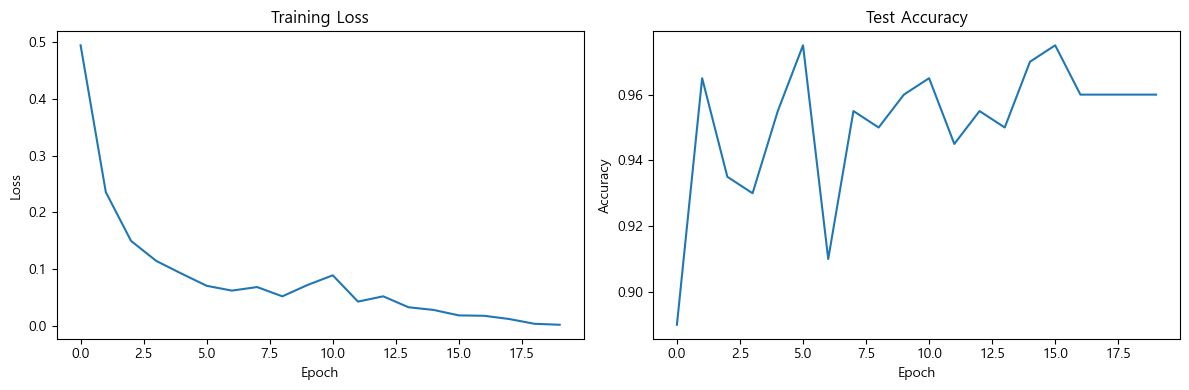

In [21]:
# 📚 학습 과정 시각화

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')

# Accuracy
axes[1].plot(history['acc'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

---
## 6. FDS에서 LSTM 적용

### 6-1. 왜 FDS에서 LSTM?

**거래 데이터의 특성**
- 동일 사용자의 연속 거래는 패턴이 있음
- 갑자기 평소와 다른 패턴 = 이상 신호

**예시: 정상 vs 사기 패턴**
```
정상 사용자:
  거래1: 편의점 5천원
  거래2: 지하철 1,400원
  거래3: 카페 4,500원
  거래4: 마트 3만원
  → 일상적 소액 패턴

사기 발생 시:
  거래1: 편의점 5천원
  거래2: 해외 면세점 200만원  ← 갑자기?
  거래3: 다른 해외 면세점 150만원  ← 연속?
  거래4: 새벽 3시 온라인 결제 80만원  ← 이상!
  → LSTM이 이 패턴 변화를 감지
```

### 6-2. 시퀀스 데이터 구성 방법

**Phase 1에서 사용할 방식**

```python
# 1. 사용자별로 거래 정렬
df_sorted = df.sort_values(['user_id', 'timestamp'])

# 2. 슬라이딩 윈도우로 시퀀스 생성
SEQ_LEN = 10  # 최근 10건의 거래를 하나의 시퀀스로

sequences = []
for user_id in df['user_id'].unique():
    user_txns = df[df['user_id'] == user_id]
    for i in range(len(user_txns) - SEQ_LEN):
        seq = user_txns.iloc[i:i+SEQ_LEN][features]
        label = user_txns.iloc[i+SEQ_LEN]['is_fraud']
        sequences.append((seq, label))
```

**시퀀스 형태**
```
입력: (batch, 10, 15)
  → 각 배치마다 10건의 거래, 거래당 15개 피처
출력: (batch, 1)
  → 다음 거래가 사기일 확률
```

### 6-3. XGBoost vs LSTM 역할 분담

| 관점 | XGBoost | LSTM |
|------|---------|------|
| 입력 | 단일 거래 | 거래 시퀀스 |
| 강점 | 정적 피처 (금액, 시간대, 카드종류) | 동적 패턴 (연속성, 변화) |
| 특성 | 빠른 학습/추론 | 복잡한 패턴 학습 |

**앙상블 전략 (Phase 1)**
```python
# XGBoost: 개별 거래 특성으로 예측
xgb_prob = xgb_model.predict_proba(single_txn)

# LSTM: 거래 시퀀스로 예측
lstm_prob = lstm_model(txn_sequence)

# 가중 평균 앙상블
final_prob = 0.6 * xgb_prob + 0.4 * lstm_prob
```

---
## 면접 Q&A

### Q: "왜 LSTM을 사용했나요?"

> "FDS에서 개별 거래뿐만 아니라 거래 패턴의 변화를 감지하고 싶었습니다. 예를 들어 평소 소액 결제만 하던 사용자가 갑자기 해외에서 고액 결제를 하면, 개별 거래로는 정상처럼 보일 수 있지만 시퀀스로 보면 이상 패턴입니다. LSTM은 이런 시계열 패턴을 잘 학습합니다."

### Q: "RNN 대신 LSTM을 선택한 이유는?"

> "RNN은 장기 의존성(long-term dependency) 문제가 있습니다. 10건 이상의 거래 시퀀스에서 초반 거래 정보가 유실되는 vanishing gradient 문제가 발생합니다. LSTM은 Cell State와 Gate 메커니즘으로 이를 해결해서 긴 시퀀스에서도 중요한 정보를 보존합니다."

### Q: "Transformer 대신 LSTM을 쓴 이유는?"

> "두 가지 이유입니다. 첫째, 거래 시퀀스 길이가 10~20건 정도로 짧아서 Transformer의 장점인 병렬 처리와 긴 시퀀스 처리가 크게 필요하지 않았습니다. 둘째, LSTM이 더 적은 파라미터로 학습이 빠르고, 실시간 추론에 유리합니다. 물론 성능 비교 실험 후 최종 결정했습니다."

### Q: "시퀀스 길이(seq_len)는 어떻게 정했나요?"

> "10건으로 설정했습니다. 너무 짧으면 패턴을 못 잡고, 너무 길면 관련 없는 오래된 거래가 포함됩니다. 5, 10, 20건으로 실험한 결과 10건에서 AUC가 가장 높았습니다. 또한 실시간 서비스에서 최근 10건은 항상 캐싱해둘 수 있는 현실적인 수치입니다."

---
## 최종 체크포인트

In [ ]:
print("=" * 60)
print("  1-S4 완료: LSTM 기초")
print("=" * 60)
print()
print("배운 것:")
print()
print("1. RNN 개념")
print("   - 순차 데이터 처리, hidden state 전달")
print("   - 한계: Vanishing Gradient")
print()
print("2. LSTM 구조")
print("   - Cell State: 장기 기억 저장소")
print("   - 3가지 Gate: Forget, Input, Output")
print()
print("3. PyTorch 기본")
print("   - Tensor, nn.Module, 학습 루프")
print("   - forward(), backward(), optimizer.step()")
print()
print("4. FDS 적용")
print("   - 거래 시퀀스로 패턴 변화 감지")
print("   - XGBoost(정적) + LSTM(동적) 앙상블")
print()
print("=" * 60)
print("다음: 1-S5 앙상블 개념")
print("=" * 60)